# <font color='DarkBlue'>Object detection

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


**Important Note**: To use a Keras function in this notebook, you will need to write: `K.function()`.

## <font color='IndianRed'>Problem Statement

Consider self-driving cars. The system takes pictures of the road ahead every few seconds while it drives. All these images are gathered into a folder and have been labelled by drawing bounding boxes around every car you found. An example is shown below.

If you have 80 classes that you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector one-hot coded vector. Because the `YOLO` model is very computationally expensive to train, we will load pre-trained weights. 

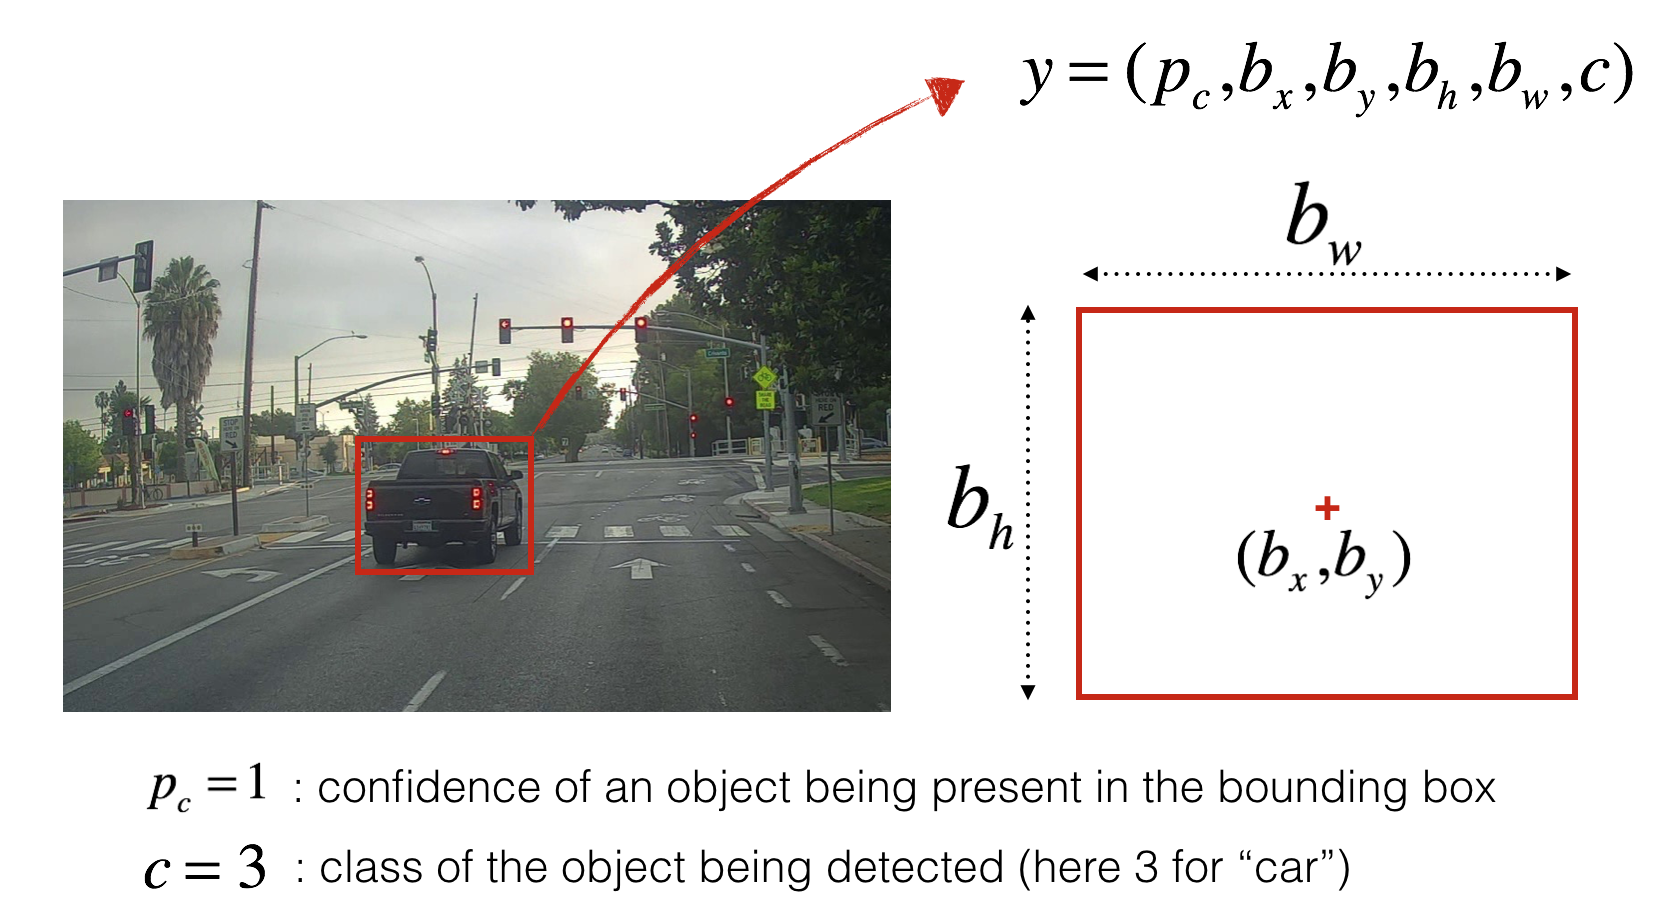

In [2]:
Image('nb_images/box_label.png', width=600, height=800)

## <font color='IndianRed'>YOLO

`You Only Look Once (YOLO)` achieves high accuracy while also being able to run in real-time. This algorithm only looks once at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### <font color='Indigo'>Model details

#### Inputs and Outputs
- **Input**  - a batch of images, and each image has the shape (m, 608, 608, 3)
- **Output** - a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen (to cover 80 classes), and stored in the file `yolo_anchors.txt`
* Dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H, n_W, anchors, classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) $\rightarrow$ CNN $\rightarrow$ ENCODING (m, 19, 19, 5, 85). 

#### Encoding
If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

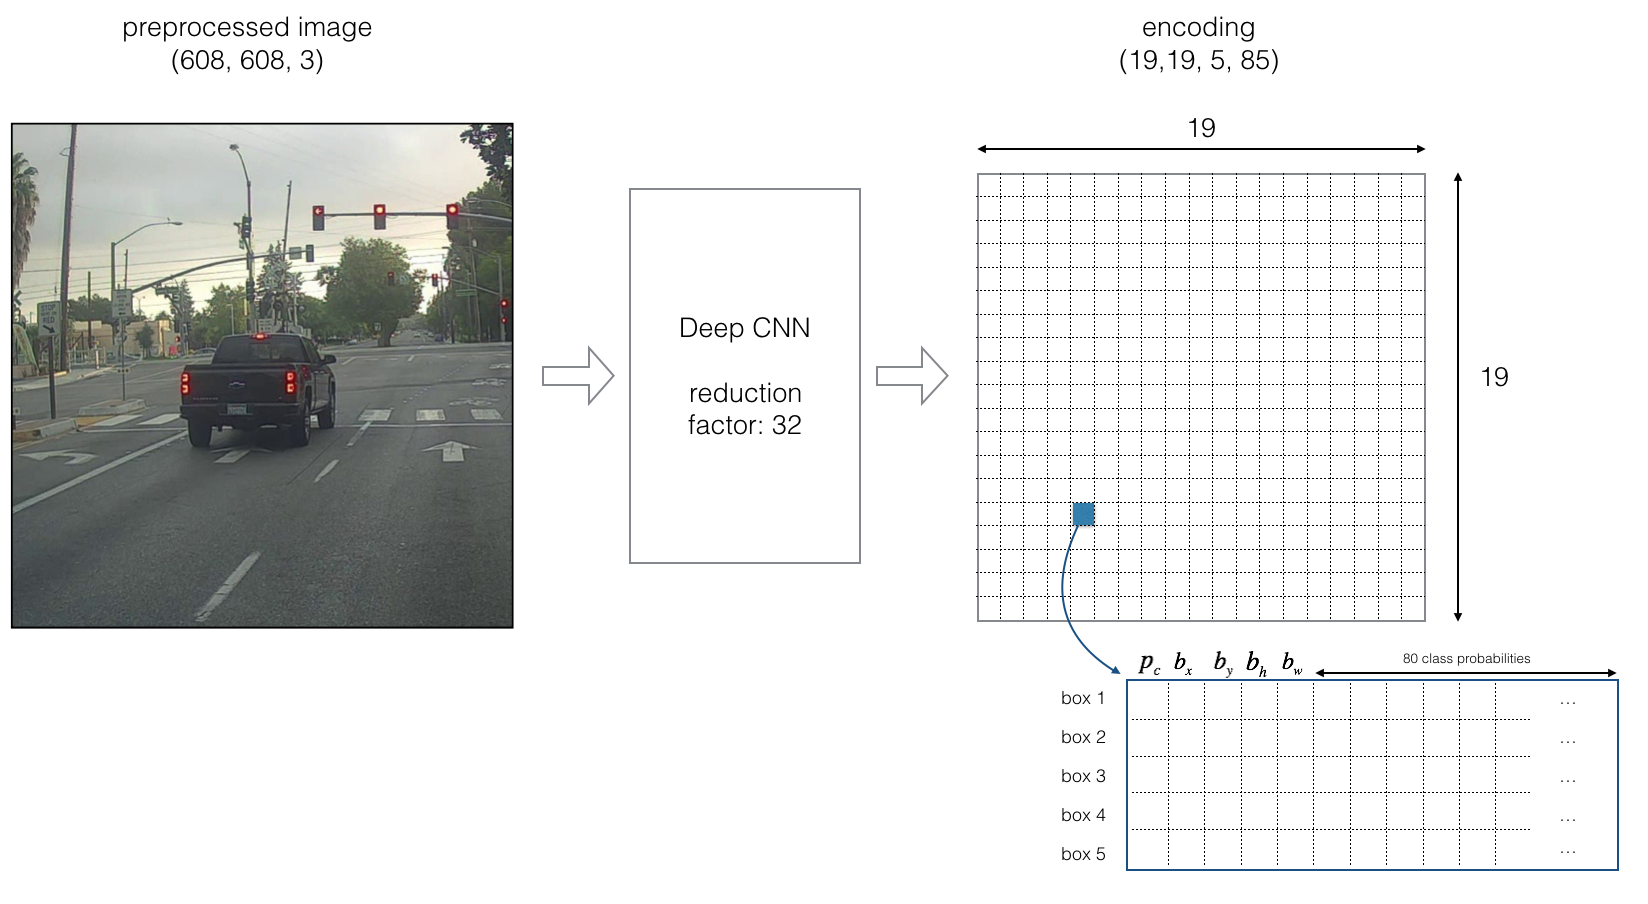

In [3]:
Image("nb_images/architecture.png", height=600, width=800)

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 anchor boxes. Anchor boxes are defined only by their width and height. For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

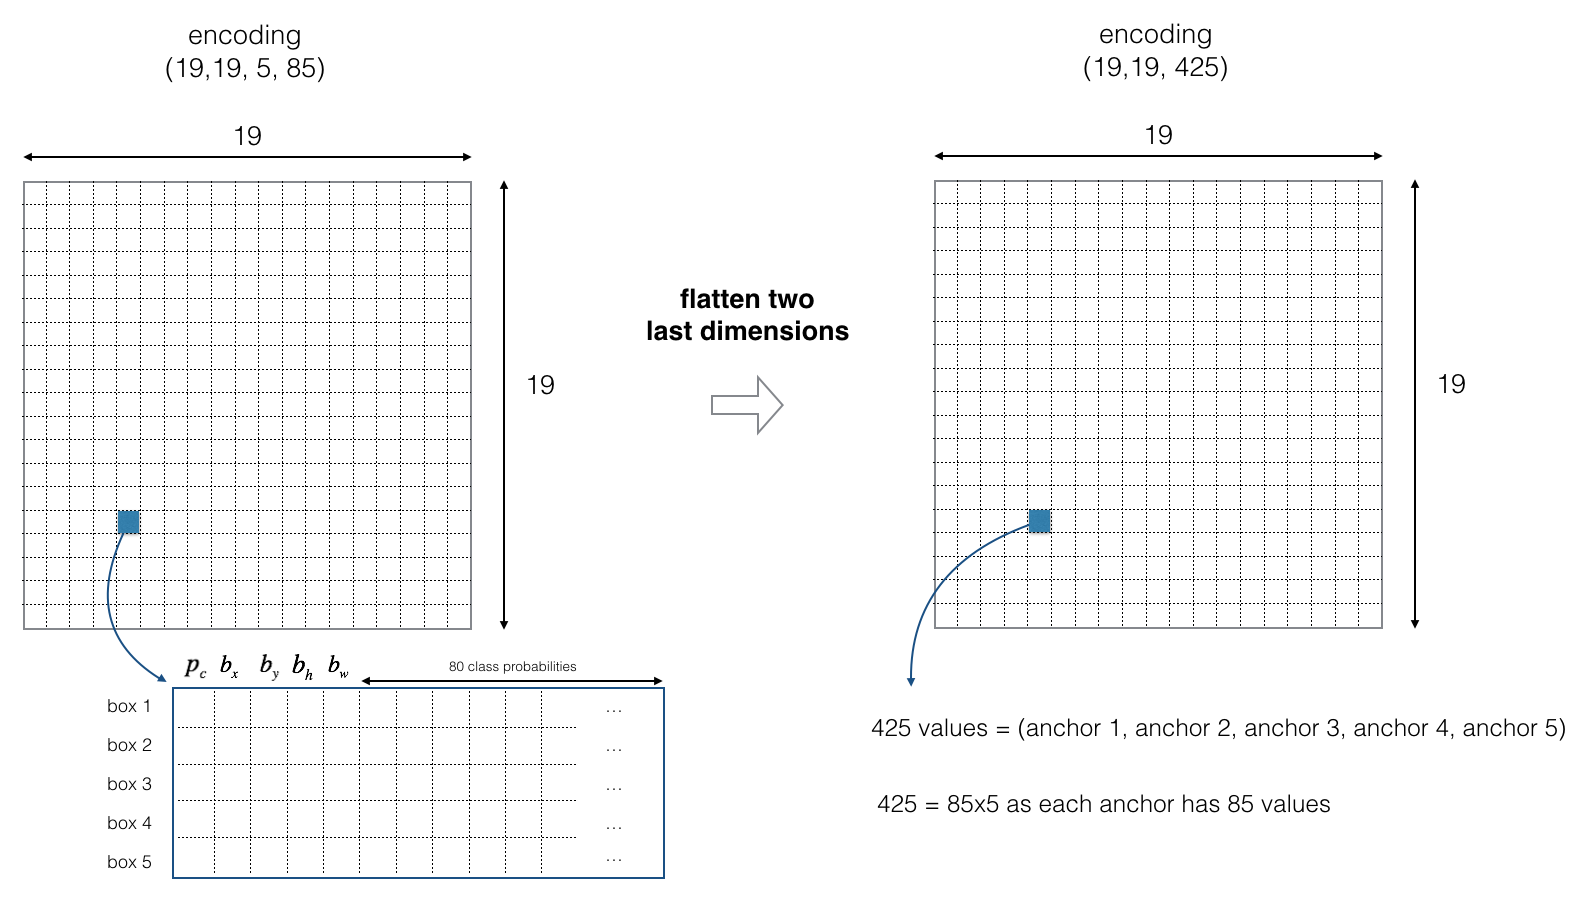

In [4]:
Image("nb_images/flatten.png", height=600, width=800)

#### Class score

Now, for each anchor box of each cell we will compute the element-wise product and extract a probability that the box contains a certain class. The class score is $Score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

#### Visualizing classes
For each of the 19x19 cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes, and max across the resultant 5 anchor probabilities).

Color that grid cell according to what object that grid cell considers the most likely. Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell

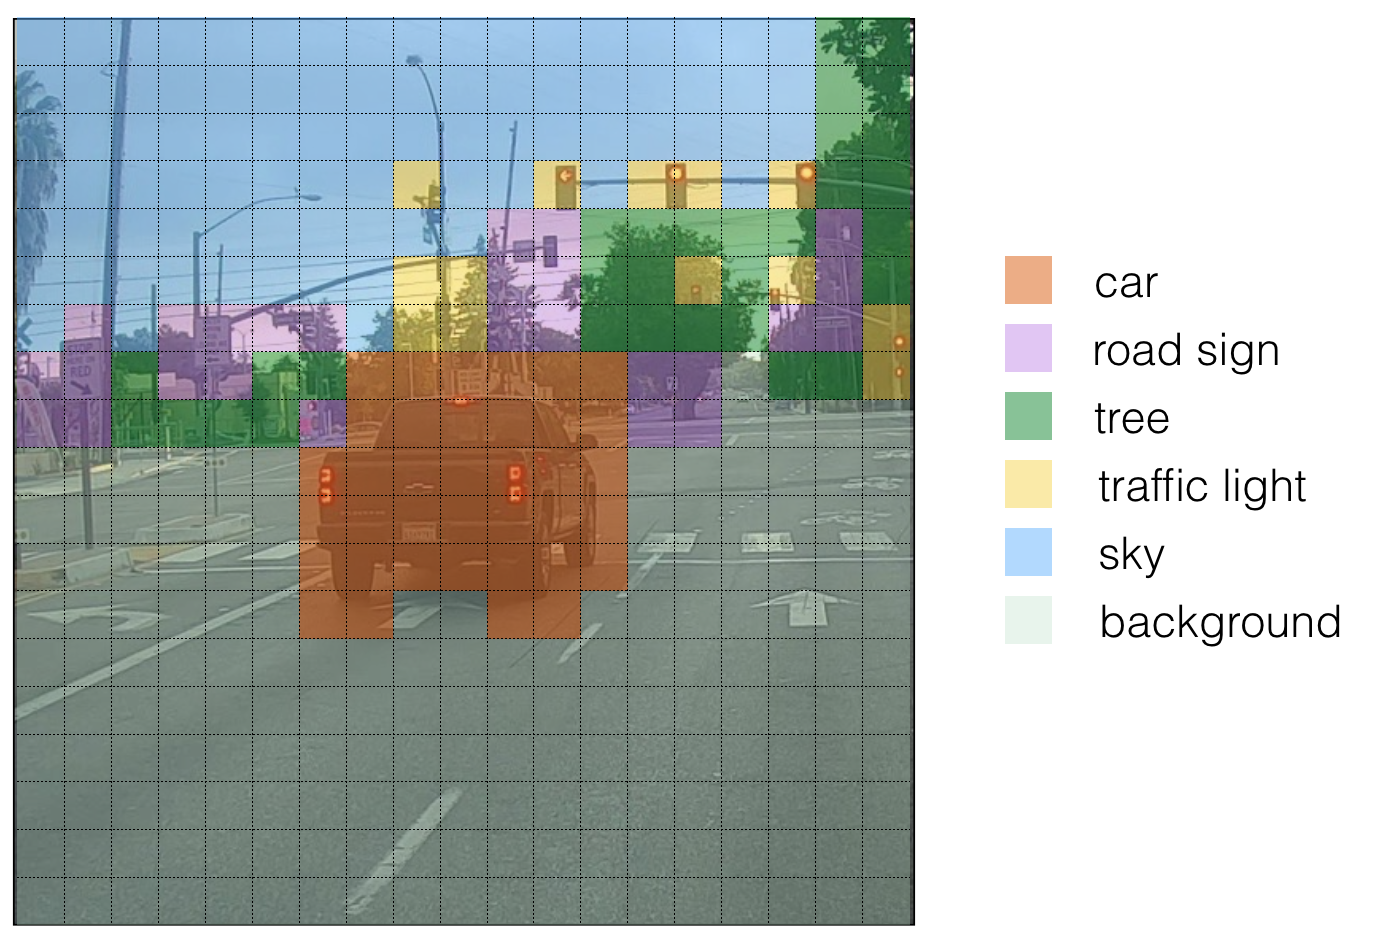

In [5]:
Image("nb_images/proba_map.png", height=600, width=800)

#### Visualizing bounding boxes
Plot the bounding boxes that YOLO outputs (with some constraint). Each cell can gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes.

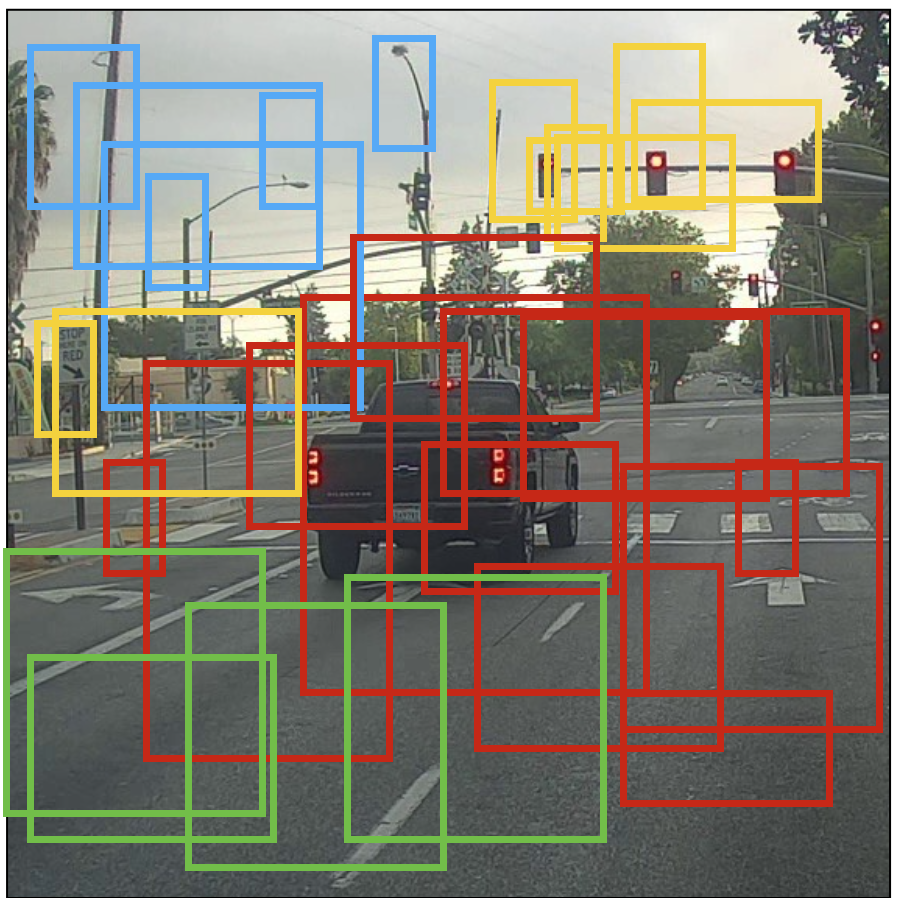

In [6]:
Image("nb_images/anchor_map.png", height=300, width=540)

#### Non-Max suppression
In the figure, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use the technique of `Non-max Suppression`.
- Get rid of boxes with a low score (Box is not confident about a class either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

### <font color='Indigo'>Filtering with a threshold on class scores



You are going to first apply a filter by thresholding. You would like to get rid of any box for which the class `score` is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each anchor box described by 85 numbers. It is convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:

- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

#### **Exercise**:  Implement `yolo_filter_boxes()`.

1. Compute box scores by doing the elementwise product ($p \times c$).  

The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b       # shape of c will be (19*19, 5, 80)
```
We are **broadcasting** (multiplying vectors of different sizes).


2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    
    **Useful functions**
        * Keras `argmax`
        * Keras `max`

    **Additional Hints**
        * For the `axis` parameter of `argmax` and `max`, if you want to select the **last** axis, one way to 
        do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the 
        last position of an array using `arrayname[-1]`.
        * Applying `max` normally collapses the axis for which the maximum is applied.  `keepdims=False` is 
        the default option, and allows that dimension to be removed.  We don't need to keep the last 
        dimension after applying the maximum here.


3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep.   

    **Useful reference**:
    * TF boolean mask. For the `tf.boolean_mask`, we can keep the default `axis=None`.

In [7]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence   -- tensor of shape (19, 19, 5, 1)
    boxes            -- tensor of shape (19, 19, 5, 4)
    box_class_probs  -- tensor of shape (19, 19, 5, 80)
    threshold        -- real value, if [ highest class probability score < threshold], 
                        then get rid of the corresponding box
    
    Returns:
    scores           -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes            -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes          -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores elecment wise -- P_c x C_i
    
    box_scores = np.multiply(box_confidence, box_class_probs)
    
    # Step 2: Find the box_classes using the max box_scores, 
    # Keep track of the corresponding score
    
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". 
    # The mask should have the same dimension as box_class_scores, and be True for the 
    #boxes you want to keep (with probability >= threshold)
    
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    
    scores  = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes   = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [8]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2]     = " + str(scores[2].eval()))
    print("boxes[2]      = " + str(boxes[2].eval()))
    print("classes[2]    = " + str(classes[2].eval()))
    print("scores.shape  = " + str(scores.shape))
    print("boxes.shape   = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2]     = 10.7506
boxes[2]      = [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
classes[2]    = 7
scores.shape  = (?,)
boxes.shape   = (?, 4)
classes.shape = (?,)


**Note** *In the test for `yolo_filter_boxes`, we're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.*

### <font color='Indigo'>Non-max suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called `Non-maximum suppression (NMS)`. It does that via **"Intersection over Union"**, or IoU.

For example, the model can predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes.

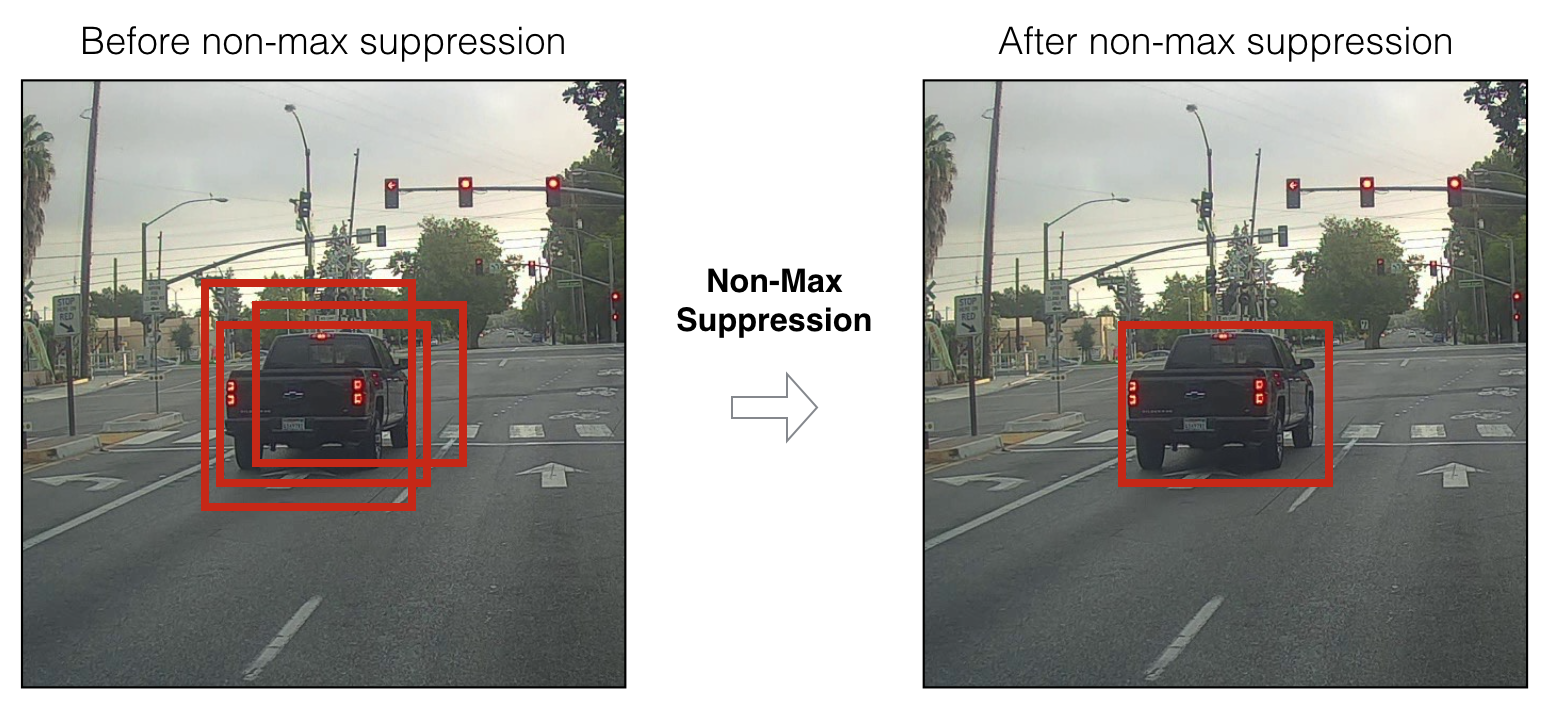

In [9]:
Image("nb_images/non-max-suppression.png", width=600, height = 450)

#### **Exercise**: Implement IOU
   - In this code, we use the convention that (0,0) is the top-left corner and (1,1) is the lower-right 
     corner. 
   - For this exercise, we define a box using its two corners: upper left $(x_1, y_1)$ and lower right
     $(x_2, y_2)$
   - To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. 
   
To find the **intersection** of the two boxes $(x_{i,1}, y_{i,1}, x_{i,2}, y_{i,2})$: 

   - The top left corner of the intersection $(x_{i,1}, y_{i,1})$ is found by comparing the 
    top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate 
    that is closer to the right, and y-coordinate that is closer to the bottom.
    
   - The bottom right corner of the intersection $(x_{i,2}, y_{i,2})$ is found by comparing 
    the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate 
    is closer to the left, and the y-coordinate that is closer to the top.
   - The two boxes may have no intersection.  You can detect this if the intersection coordinates 
   you end up is the top right and/or bottom left corners of an intersection box.  
   Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and 
   find that at least one of these lengths is negative, then there is no intersection 
   (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is 
    still zero. This happens when either the height or width (or both) of the calculated intersection 
    is zero.

In [10]:
def iou(box1, box2):
    
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection 
    # of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_width  = xi1 - xi2
    inter_height = yi1 - yi2
    inter_area   = inter_width * inter_height
    
    # Calculate the Union area by using Formula: 
    # Union(A,B) = A + B - Inter(A,B)
    
    box1_area  = (box1[3] - box1[1]) * (box1[2]- box1[0])
    box2_area  = (box2[3] - box2[1]) * (box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area
        
    iou = inter_area/union_area
    return iou

In [11]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("Intersecting boxes      = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("Non-intersecting boxes  = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("Boxes touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("Boxes touch at edges    = " + str(iou(box1,box2)))

Intersecting boxes      = 0.14285714285714285
Non-intersecting boxes  = 1.0
Boxes touch at vertices = 0.0
Boxes touch at edges    = 0.0


#### <font color='Indigo'>YOLO Non-max Suppression

1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: 

Implement `yolo_non_max_suppression()` using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):

** Reference documentation ** 
- **`tf.image.non_max_suppression()`**

```python
    tf.image.non_max_suppression(boxes, scores, max_output_size, iou_threshold=0.5, name=None)
```

- **`keras.gather()`**
 
    Even though the documentation shows `tf.keras.backend.gather()`, you can use `keras.gather()`.  
```python
keras.gather(reference, indices)
```

In [12]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores  -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes   -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the 
               image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes     -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores  -- tensor of shape (, None), predicted score for each box
    boxes   -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in 
                                                                # tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, 
                                               iou_threshold=iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores  = K.gather(scores, nms_indices)
    boxes   = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [13]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2]    = " + str(scores[2].eval()))
    print("boxes[2]     = " + str(boxes[2].eval()))
    print("classes[2]   = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape  = " + str(boxes.eval().shape))
    print("class shape  = " + str(classes.eval().shape))

scores[2]    = 6.9384
boxes[2]     = [-5.299932    3.13798141  4.45036697  0.95942086]
classes[2]   = -2.24527
scores.shape = (10,)
boxes.shape  = (10, 4)
class shape  = (10,)


### <font color='Indigo'>Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions implemented. 

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions: 

```python
    boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`


```python
    boxes = scale_boxes(boxes, image_shape)
```
YOLO network was trained to run on 608x608 images. If you are testing this data on a different size image, 
this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

In [14]:
# yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, 
    box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape     -- tensor of shape (2,) containing the input shape, in this notebook 
                       we use (608., 608.) (has to be float32 dtype)
    max_boxes       -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], 
                       then get rid of the corresponding box
    iou_threshold   -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores  -- tensor of shape (None, ), predicted score for each box
    boxes   -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and 
    # box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a 
    # threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, 
                                               threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold.
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, 
                                                      max_boxes = max_boxes, 
                                                      iou_threshold = iou_threshold)
    
    return scores, boxes, classes

In [15]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2]    = " + str(scores[2].eval()))
    print("boxes[2]     = " + str(boxes[2].eval()))
    print("classes[2]   = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape  = " + str(boxes.eval().shape))
    print("class shape  = " + str(classes.eval().shape))

scores[2]    = 138.791
boxes[2]     = [ 1292.32971191  -278.52166748  3876.98925781  -835.56494141]
classes[2]   = 54
scores.shape = (10,)
boxes.shape  = (10, 4)
class shape  = (10,)


## Summary of operations
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in the 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

## <font color='IndianRed'>Test YOLO pre-trained model

In [16]:
sess = K.get_session()

### <font color='Indigo'>Defining classes, anchors and image shape

* Recall that we are trying to detect 80 classes, and have 5 anchor boxes. 
* We have gathered the information on the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". 
* We'll read class names and anchors from text files.
* The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [17]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

### <font color='Indigo'>Loading a pre-trained model

Load an existing pre-trained Keras YOLO model stored in `yolo.h5`. 

In [18]:
yolo_model = load_model("model_data/yolo.h5", compile=False)

In [19]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85)

### <font color='Indigo'>Convert output of the model to usable Bounding box tensors

The output of `yolo_model` is a `(m, 19, 19, 5, 85)` tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you. Done via `yolo_head` 

*Reference:* 

`keras_yolo.py` : https://github.com/allanzelener/YAD2K/blob/master/yad2k/models/keras_yolo.py.

In [20]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by `yolo_eval()`.

### <font color='Indigo'>Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Let's now call `yolo_eval`, which you had previously implemented, to do this. 

In [21]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### <font color='Indigo'>Run the graph on an image

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

**Exercise**: Implement predict() which runs the graph to test YOLO on an image.
You will need to run a TensorFlow session, to have it compute `scores, boxes, classes`.

The code below also uses the following function:
```python
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- `image`: a python (PIL) representation of your image used for drawing boxes.
- `image_data`: a numpy-array representing the image. This will be the input to the CNN.

**Important note**: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict `{K.learning_phase(): 0}`.

**Using the TensorFlow Session object**

* Recall that above, we called `K.get_Session()` and saved the Session object in `sess`.
* To evaluate a list of tensors, we call `sess.run()` like this:
```
sess.run(fetches=[tensor1,tensor2,tensor3],
         feed_dict={yolo_model.input: the_input_variable,
                    K.learning_phase():0}
```
* Notice that the variables `scores, boxes, classes` are not passed into the `predict` function, but these are global variables that you will use within the `predict` function.

In [22]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". 
    Prints and plots the predictions.
    
    Arguments:
    sess       -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores   -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes    -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes  -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], 
                                                  feed_dict={yolo_model.input: image_data, 
                                                             K.learning_phase(): 0})
    

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


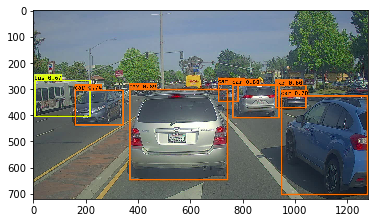

In [23]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

**References**: 

- Joseph Redmon et al.,`YOLO`, https://arxiv.org/abs/1506.02640 (2015)
- Joseph Redmon et al.,`YOLO9000` https://arxiv.org/abs/1612.08242 (2016)
- Allan Zelener - `YAD2K: Yet Another Darknet 2 Keras`, https://github.com/allanzelener/YAD2K
- YOLO website - `https://pjreddie.com/darknet/yolo/`